In [1]:
!pip install tensorflow-gpu

In [2]:
!pip install textacy

In [3]:
!python -m spacy download en_core_web_lg


✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [4]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [64]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from collections import Counter
from seaborn import heatmap
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import re

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [6]:
from spacy.tokens import Doc, Token, Span

import gensim


In [7]:

import en_core_web_lg
nlp = en_core_web_lg.load()


In [8]:
df= pd.read_csv('story_data.csv',index_col='index' )

In [9]:
df=df[['story_title', 'story_text', 'book_id', 'book_author', 'book_title']]

In [10]:
def word_count(string):
    return len(string.split(' '))

In [11]:
def flag_acknowledgments(string):
  return 'acknowledgment' in string.lower()

In [13]:
def remove_underscores_spaces(story):
  split_string=story.split(' ')
  return ' '.join([word.replace('_','') for word in split_string if ' ' not in word])

In [14]:
df['clean_text'] = df.story_text.apply(lambda x: remove_underscores_spaces(x))

In [15]:
df['word_count']= df.story_text.map(lambda x: word_count(x))

In [16]:
df['flag_acknow']=df.story_title.apply(flag_acknowledgments)

In [17]:
df.drop(index=df[df.flag_acknow==True].index, inplace=True)

In [18]:
new_df= df[(df.word_count>50)&(df.word_count<=10000)]
new_df.reset_index(inplace=True)

PREPROCESSING WITH SPACY

In [19]:
def gpu_nlp_pipe(series_of_texts):
  with tf.device('/device:GPU:0'):
    docs=list(nlp.pipe(series_of_texts, batch_size=100))
    return docs

In [19]:
'''
def batch_texts(series_of_texts, batch_size):
  num_texts=len(series_of_texts)
  num_batches=num_texts//batch_size
  last_batch_size=num_texts-num_texts*num_batches
  batch_names = ['batch_'+str(i) for i in range(1, num_batches+1)]
  batch_dict={}

  for i in range(num_batches):
    if i==num_batches-1:
      batch_dict[batch_names[i]]= series_of_texts[batch_size*i:batch_size*i+last_batch_size]
    else:
      batch_dict[batch_names[i]]= series_of_texts[batch_size*i:batch_size*i+batch_size]
  return batch_dict


In [21]:
'''
batch_dict = batch_texts(new_df.clean_text, 1000)
list_of_docs=[]

In [ ]:
'''
for value in batch_dict.values():
  list_of_docs+=gpu_nlp_pipe(value)

In [ ]:
token.  

In [20]:
def check_stop_punct(token):
    if token.is_stop or token.is_punct:
        return False
    else:
        return True

def clean_doc_lem_stop(document):
    no_stop_li = list(filter(check_stop_punct, document))
    lemma_li = list(map(lambda x: x.lemma_, no_stop_li))
    spaces=[True for word in lemma_li]
    doc=Doc(nlp.vocab, words=lemma_li, spaces=spaces)
    return doc


In [73]:
nlp.add_pipe(clean_doc_lem_stop, first=True)
nlp.pipe_names

['clean_doc_lem_stop', 'tagger', 'parser', 'ner']

In [72]:
nlp.remove_pipe('clean_doc_lem_stop')

('clean_doc_lem_stop', <function __main__.clean_doc_lem_stop>)

In [22]:
mini_df=new_df.sample(frac=0.2)

In [122]:
mini_df.head

<bound method NDFrame.head of        index                                        story_title                                         story_text  book_id                         book_author                                         book_title                                         clean_text  word_count  flag_acknow
19880  20557                              Xiv. The Magic Packet  |A POOR man, called Iena, or the Wanderer, was...    48469             Schoolcraft, Henry Rowe   The Indian Fairy Book\nFrom the Original Legends  |A POOR man, called Iena, or the Wanderer, was...         677        False
2565    2633                           The Value Of A Good Name  Samuel Appleton, a distinguished Boston mercha...    29357                         frozenset()                 Our Young Folks at Home and Abroad  Samuel Appleton, a distinguished Boston mercha...         186        False
17396  17911          Mus'Ab Bin Al-Zubayr And Ayishah His Wife  It is told of Mus'ab bin that he met in Al- 

In [23]:
mini_df = mini_df[['story_title', 'story_text', 'book_id', 'book_author', 'book_title', 'clean_text', 'word_count']]

In [74]:
mini_df['docs']=gpu_nlp_pipe(mini_df.clean_text)

In [75]:
docs=mini_df.docs.array

In [25]:
mini_df.head()

,story_title,story_text,book_id,book_author,book_title,clean_text,word_count,docs
9424,"_Published January, 1911_","THE QUINN & BODEN CO. PRESS RAHWAY, ...",41765,frozenset(),Half a Hundred Hero Tales of Ulysses and The M...,"THE QUINN & BODEN CO. PRESS RAHWAY, ...",446,"(QUINN, BODEN, CO, press, , RAHWAY, ..."
9190,Bellerophon,"Bellerophon, grandson of Sisyphus, received fr...",59956,"('Schmidt, Ferdinand', 'Becker, Karl Friedrich')",Gods and Heroes,"Bellerophon, grandson of Sisyphus, received fr...",760,"(Bellerophon, grandson, Sisyphus, receive, god..."
15339,Cupid'S Garden,O chaste and sweet are the flowers that blow ...,37111,"Fitz-Gerald, S. J. Adair (Shafto Justin Adair)",The Zankiwank and The Bletherwitch: An Origina...,O chaste and sweet are the flowers that blow ...,1116,"(o, chaste, sweet, flower, blow, , Cupid, Ga..."
2615,More Presents,"""With so many birthdays in one family, we must...",4784,"Lawrence, Josephine",Brother and Sister,"""With so many birthdays in one family, we must...",1066,"(birthday, family, elaborate, expensive, prese..."
5494,The Man In The Moon,"Said the Raggedy Man on a hot afternoon, ""M...",19993,frozenset(),Childhood's Favorites and Fairy Stories\nThe Y...,"Said the Raggedy Man on a hot afternoon, ""M...",529,"(say, Raggedy, Man, hot, afternoon, , ..."


In [ ]:
new_df.story_title.value_counts(ascending=False)[:20]

In [95]:


mini_df.loc[18128, 'docs']

New Zealand   time live man name Kahukura even way distant village come lonely spot seashore walk slowly see large pile head tail fish lie beach day man net oblige catch fish spear hook Kahukura see pile astonish luck exclaim hard catch fish head tail thousand look closely footprint sand mortal fish cry Fairies watch night darkness come return spot hide rock wait long time see fleet tiny canoe come spin wave range line distance shore Kahukura little figure bend pull hear small voice shout net net little figure drop overboard begin haul shore singe sweetly canoe draw near land Kahukura see crowd Fairies spring beach begin drag ashore great net fill fish Fairies struggle net Kahukura join haul away rope fair man skin white Fairies notice pull away pull away soon net land Fairies run forward divide catch peep dawn hurry fish carry Fairy string share run twig gill string fish keep call another:-- Hurry hurry finish sun rise Kahukura short string knot end string share fill lift string knot 

In [96]:
# all tokens that arent stop words or punctuations
word_list = [token for doc in mini_df.docs for token in doc if token.is_stop != True and token.is_punct != True]

# noun tokens that arent stop words or punctuations
noun_list = [token for doc in mini_df.docs for token in doc if token.pos_ == "NOUN"]

verb_list= [token for doc in mini_df.docs for token in doc if token.pos_ == "VERB"]


In [90]:
c = Counter(word_list )
bar_data=word_freq.most_common(100)
del c['          ']
del c[' ']
bar_data

[(QUINN, 1),
 (BODEN, 1),
 (CO, 1),
 (PRESS, 1),
 (          , 1),
 (RAHWAY, 1),
 (N., 1),
 (J., 1),
 (  , 1),
 (PREFACE, 1),
 ( , 1),
 (apology, 1),
 (offer, 1),
 (add, 1),
 (book, 1),
 (Classical, 1),
 (Stories, 1),
 (endless, 1),
 (exist, 1),
 (version, 1),
 (ancient, 1),
 (modern, 1),
 (verse, 1),
 (prose, 1),
 (plea, 1),
 (Vivien, 1),
 (offer, 1),
 (Merlin, 1),
 (tender, 1),
 (rhyme, 1),
 (  , 1),
 (live, 1),
 (dispersedly, 1),
 (hand, 1),
 (  , 1),
 (minstrel, 1),
 (sing, 1),
 (differently, 1),
 (Greek, 1),
 (Egyptian, 1),
 (priest, 1),
 (Herodotus, 1),
 (child, 1),
 (Greece, 1),
 (lose, 1),
 (secret, 1),
 (eternal, 1),
 (youth, 1),
 (tale, 1),
 (Troy, 1),
 (divine, 1),
 (Thebes, 1),
 (Pelops, 1),
 (line, 1),
 (song, 1),
 (sweet, 1),
 (Colonus, 1),
 (cruel, 1),
 (death, 1),
 (Pyramus, 1),
 (Thisby, 1),
 (Dido, 1),
 (willow, 1),
 (hand, 1),
 (old, 1),
 (story, 1),
 (Homer, 1),
 (Sophocles, 1),
 (Virgil, 1),
 (Ovid, 1),
 (lose, 1),
 (gloss, 1),
 (freshness, 1),
 (innocent, 1),
 (br

In [79]:
index= [word for word, value in bar_data]
values= [value for word, value in bar_data]

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


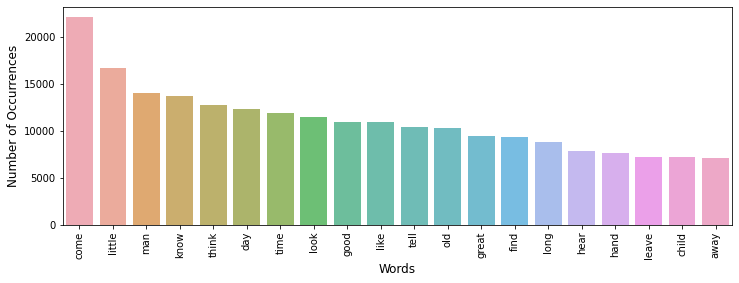

<Figure size 432x288 with 0 Axes>

In [70]:
index= [word for word, value in bar_data]
values= [value for word, value in bar_data]

plt.figure(figsize=(12,4))
sns.barplot(index, values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Words', fontsize=12)
plt.xticks(rotation=90)
plt.show();
plt.savefig('freq_words.png')

In [102]:
noun_text=[token.lower_ for token in noun_list]

In [106]:
noun_freq = Counter(noun_text)
bar_data= noun_freq.most_common(20)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


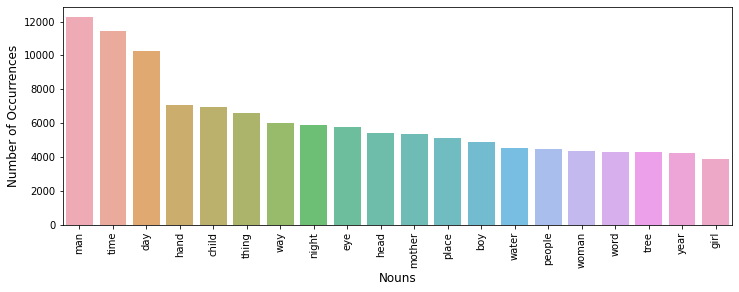

<Figure size 432x288 with 0 Axes>

In [108]:
index= [word for word, value in bar_data]
values= [value for word, value in bar_data]

plt.figure(figsize=(12,4))
sns.barplot(index, values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Nouns', fontsize=12)
plt.xticks(rotation=90)
plt.show();
plt.savefig('freq_nouns.png')

In [110]:
verb_text=[token.lower_ for token in verb_list]
verb_freq = Counter(verb_text)
bar_data = verb_freq.most_common(20)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


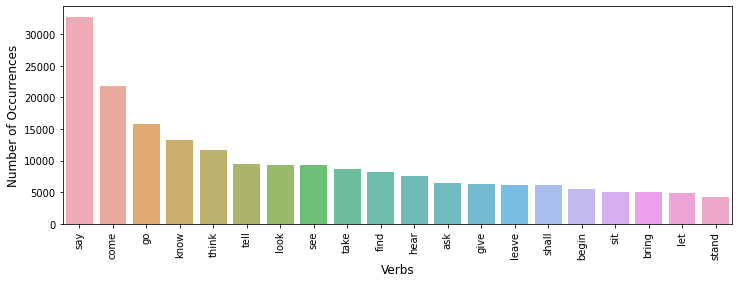

<Figure size 432x288 with 0 Axes>

In [111]:
index= [word for word, value in bar_data]
values= [value for word, value in bar_data]

plt.figure(figsize=(12,4))
sns.barplot(index, values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Verbs', fontsize=12)
plt.xticks(rotation=90)
plt.show();
plt.savefig('freq_verbs.png')

# LDA Topic Modeling

In [112]:
import gensim 
from gensim import corpora 
from gensim.models import LdaModel, LdaMulticore 
import gensim.downloader as api 
from gensim.utils import simple_preprocess, lemmatize 
import textacy.vsm 
import textacy.tm

In [113]:

vectorizer = textacy.vsm.Vectorizer(tf_type="linear", apply_idf=True, idf_type="smooth", norm="l2",min_df=2, max_df=0.95)
doc_term_matrix = vectorizer.fit_transform((doc._.to_terms_list(ngrams=1, entities=True, as_strings=True) for doc in mini_df.docs))

In [114]:
model = textacy.tm.TopicModel("nmf", n_topics=25)
model.fit(doc_term_matrix)
doc_topic_matrix = model.transform(doc_term_matrix)

for topic_idx, top_terms in model.top_topic_terms(vectorizer.id_to_term, top_n=25):
  print("topic", topic_idx, ":", "   ".join(top_terms))

topic 0 : come   man   time   know   day   think   old   look   find   like   great   long   tell   hand   hear   night   way   good   leave   house   young   place   stand   head   away
topic 1 : thou   thy   o   Allah   hath   King   Quoth   hast   ✿   quoth   God   till   unto   man   art   merchant   thine   Wazir   answer   Sultan   shall   wilt   lord   slay   come
topic 2 : book   story   read   child   tale   volume   edition   write   p.   page   interest   author   literature   fairy   picture   Tales   illustration   vol   work   study   Story   version   history   pp   print
topic 3 : little   child   mother   girl   baby   dear   look   old   think   oh   mamma   Mrs.   come   good   Mary   like   pretty   play   love   flower   poor   sister   Miss   doll   know
topic 4 : king   princess   prince   queen   palace   daughter   vizier   son   fairy   kingdom   youth   castle   shall   court   come   royal   send   golden   father   majesty   brother   wife   bid   dragon   

In [62]:
doc_topic_matrix

array([[0.01075951, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02936499, 0.01456444, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.04450397, 0.        , 0.00776316, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.06645444, 0.        , 0.02483855, ..., 0.        , 0.        ,
        0.        ],
       [0.00317817, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00545456, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])